In [1]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14814857070827711411,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5757803803913364981
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6918604064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10876337927658090511
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8287833588318289808
 physical_device_desc: "device: XLA_GPU device"]

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, concatenate
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

In [5]:
epochs = 100
batch_size = 5
image_size = 224

In [6]:
#load train data(25000 imgs each)

filenames = os.listdir('./input/train/train')
data = []
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    
    image = keras.preprocessing.image.load_img(os.path.join('./input/train/train', filename),
                                               color_mode='rgb',
                                               target_size= (image_size,image_size))
    image = np.array(image)
    data.append(image)

data = np.array(data)
categories = np.array(categories)

print(data)
print(categories)

[[[[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 203 119]
   [241 202 123]
   [239 200 121]]

  [[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 205 120]
   [242 203 124]
   [240 201 122]]

  [[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 204 122]
   [243 204 125]
   [241 202 123]]

  ...

  [[154 123  56]
   [155 124  57]
   [156 125  58]
   ...
   [  3   3   1]
   [  3   3   1]
   [  3   3   1]]

  [[153 122  55]
   [153 122  55]
   [154 123  56]
   ...
   [  2   2   0]
   [  2   2   0]
   [  2   2   0]]

  [[151 120  53]
   [152 121  54]
   [153 122  55]
   ...
   [  1   1   0]
   [  1   1   0]
   [  1   1   0]]]


 [[[ 39  44  40]
   [ 40  44  43]
   [ 41  45  46]
   ...
   [210 209 181]
   [207 204 171]
   [201 199 161]]

  [[ 40  45  41]
   [ 40  44  43]
   [ 41  45  46]
   ...
   [207 203 176]
   [203 200 169]
   [197 195 157]]

  [[ 39  44  40]
   [ 38  42  41]
   [ 37  41  42]
   ...
   [195 191 166]
   [198 193 164]
   [205 200

In [7]:
# shuffle dataset

idx = np.random.permutation(len(data))
data, categories = data[idx], categories[idx]

In [8]:
# split train 6(15,000) / val 2(5,000) / test 2(5,000)

x_train = data[:15000]
y_train = categories[:15000]
x_temp, y_temp = data[-10000:], categories[-10000:]

from sklearn.model_selection import train_test_split

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

In [9]:
print(x_train, y_train)

print(x_temp, y_temp)
print(x_temp.shape, y_temp.shape)

print(x_val, y_val)

print(x_test, y_test)
print(x_test.shape, y_test.shape)

[[[[255 254 255]
   [255 254 255]
   [255 254 255]
   ...
   [255 255 251]
   [254 255 250]
   [254 255 250]]

  [[255 254 255]
   [255 254 255]
   [255 254 255]
   ...
   [255 255 251]
   [254 255 250]
   [254 255 250]]

  [[255 254 255]
   [255 254 255]
   [255 255 255]
   ...
   [249 249 247]
   [254 254 252]
   [254 254 252]]

  ...

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 253]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]

  [[255 255 255]
   [255 255 255]
   [255 255 255]
   ...
   [255 255 255]
   [255 255 255]
   [255 255 255]]]


 [[[ 55  28   7]
   [ 52  24   2]
   [ 53  25   3]
   ...
   [144 139 119]
   [137 132 112]
   [134 129 109]]

  [[ 53  25   3]
   [ 51  23   1]
   [ 54  26   4]
   ...
   [142 137 117]
   [137 132 112]
   [137 132 112]]

  [[ 51  23   1]
   [ 51  23   1]
   [ 55  27   5]
   ...
   [143 138 118]
   [138 133 113]
   [138 133

In [10]:
# data augmentation in train set (train 15,000 to 75,000)

x_train_temp = x_train
y_train_temp = y_train

x_train_aug = []
y_train_aug = []

for img, label in zip(x_train_temp, y_train_temp):
    curImg = img
    
    flipped1 = tf.image.flip_left_right(curImg)
    flipped2 = tf.image.flip_up_down(curImg)
    
    x_train_aug.append(flipped1)
    x_train_aug.append(flipped2)
    
    for i in range(3):
        cropped = curImg[random.randrange(0,100):random.randrange(180,225), random.randrange(0,100):random.randrange(180,225)]
        cropped = cv2.resize(cropped, (image_size, image_size))
        x_train_aug.append(cropped)
    
    for i in range(0, 5):
        y_train_aug.append(label)
        
x_train_aug = np.array(x_train_aug)
y_train_aug = np.array(y_train_aug)

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

In [11]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu',
                       kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    module = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return module

In [12]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(0.2)

In [13]:
input_layer = Input(shape=(image_size, image_size, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2',
           kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128,
                     filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192,
                     filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208,
                     filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(2, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224,
                     filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256,
                     filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288,
                     filters_5x5_reduce=32, filters_5x5=64, filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(2, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320,
                     filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320,
                     filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384,
                     filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(2, activation='softmax', name='output')(x)


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/r

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/repli

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/r

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task

In [14]:
%load_ext tensorboard

import datetime

In [15]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalN

In [16]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy']
)

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:lo

In [17]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

conv2d_55 (Conv2D)              (None, 7, 7, 128)    106624      max_pooling2d_8[0][0]            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 4, 4, 128)    65664       average_pooling2d[0][0]          
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 4, 4, 128)    67712       average_pooling2d_1[0][0]        
__________________________________________________________________________________________________
inception_5b (Concatenate)      (None, 7, 7, 1024)   0           conv2d_50[0][0]                  
                                                                 conv2d_52[0][0]                  
                                                                 conv2d_54[0][0]                  
                                                                 conv2d_55[0][0]                  
__________

In [18]:
log_dir = "logs/inception_da/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [20]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * 0.96
    
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [21]:
%tensorboard --logdir logs/inception_da

Reusing TensorBoard on port 6006 (pid 18636), started 7:22:49 ago. (Use '!kill 18636' to kill it.)

In [22]:
# without early stopping

epochs = 30

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    validation_data=(x_val, y_val),
    # validation_steps=x_val.size//batch_size,
    # steps_per_epoch=x_train.size//batch_size,
    verbose=1,
    callbacks=[tensorboard_callback, lr_scheduler]
)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /j

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:lo

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device 

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:loc

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localho

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /j

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost

 71/469 [===>..........................] - ETA: 26s - loss: 2.7035 - output_loss: 0.8199 - auxilliary_output_1_loss: 1.0904 - auxilliary_output_2_loss: 0.7932 - output_accuracy: 0.4820 - auxilliary_output_1_accuracy: 0.5097 - auxilliary_output_2_accuracy: 0.5079Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


115/469 [======>.......................] - ETA: 23s - loss: 2.4757 - output_loss: 0.7795 - auxilliary_output_1_loss: 0.9393 - auxilliary_output_2_loss: 0.7569 - output_accuracy: 0.4989 - auxilliary_output_1_accuracy: 0.5106 - auxilliary_output_2_accuracy: 0.5098Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


159/469 [=========>....................] - ETA: 20s - loss: 2.3732 - output_loss: 0.7609 - auxilliary_output_1_loss: 0.8716 - auxilliary_output_2_loss: 0.7408 - output_accuracy: 0.5012 - auxilliary_output_1_accuracy: 0.5028 - auxilliary_output_2_accuracy: 0.5024Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


203/469 [===========>..................] - ETA: 17s - loss: 2.3145 - output_loss: 0.7506 - auxilliary_output_1_loss: 0.8332 - auxilliary_output_2_loss: 0.7307 - output_accuracy: 0.5054 - auxilliary_output_1_accuracy: 0.5023 - auxilliary_output_2_accuracy: 0.5048Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


247/469 [==============>...............] - ETA: 14s - loss: 2.2779 - output_loss: 0.7445 - auxilliary_output_1_loss: 0.8087 - auxilliary_output_2_loss: 0.7247 - output_accuracy: 0.5042 - auxilliary_output_1_accuracy: 0.4987 - auxilliary_output_2_accuracy: 0.5024Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


291/469 [=================>............] - ETA: 11s - loss: 2.2513 - output_loss: 0.7401 - auxilliary_output_1_loss: 0.7912 - auxilliary_output_2_loss: 0.7199 - output_accuracy: 0.5040 - auxilliary_output_1_accuracy: 0.5012 - auxilliary_output_2_accuracy: 0.5027Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


335/469 [====================>.........] - ETA: 8s - loss: 2.2297 - output_loss: 0.7347 - auxilliary_output_1_loss: 0.7785 - auxilliary_output_2_loss: 0.7165 - output_accuracy: 0.5055 - auxilliary_output_1_accuracy: 0.4997 - auxilliary_output_2_accuracy: 0.5016Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


379/469 [=======================>......] - ETA: 5s - loss: 2.2140 - output_loss: 0.7314 - auxilliary_output_1_loss: 0.7687 - auxilliary_output_2_loss: 0.7139 - output_accuracy: 0.5043 - auxilliary_output_1_accuracy: 0.5000 - auxilliary_output_2_accuracy: 0.5024Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


423/469 [==========================>...] - ETA: 3s - loss: 2.2012 - output_loss: 0.7282 - auxilliary_output_1_loss: 0.7611 - auxilliary_output_2_loss: 0.7119 - output_accuracy: 0.5038 - auxilliary_output_1_accuracy: 0.4994 - auxilliary_output_2_accuracy: 0.5005Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


467/469 [============================>.] - ETA: 0s - loss: 2.1905 - output_loss: 0.7257 - auxilliary_output_1_loss: 0.7548 - auxilliary_output_2_loss: 0.7101 - output_accuracy: 0.5033 - auxilliary_output_1_accuracy: 0.4987 - auxilliary_output_2_accuracy: 0.5004Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.1901 - output_loss: 0.7255 - auxilliary_output_1_loss: 0.7545 - auxilliary_output_2_loss: 0.7101 - output_accuracy: 0.5034 - auxilliary_output_1_accuracy: 0.4988 - auxilliary_output_2_accuracy: 0.5008Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/

 84/469 [====>.........................] - ETA: 24s - loss: 2.0922 - output_loss: 0.7059 - auxilliary_output_1_loss: 0.6931 - auxilliary_output_2_loss: 0.6932 - output_accuracy: 0.4993 - auxilliary_output_1_accuracy: 0.5015 - auxilliary_output_2_accuracy: 0.5067Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


128/469 [=======>......................] - ETA: 22s - loss: 2.0926 - output_loss: 0.7059 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4956 - auxilliary_output_1_accuracy: 0.4946 - auxilliary_output_2_accuracy: 0.5024Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


172/469 [==========>...................] - ETA: 19s - loss: 2.0930 - output_loss: 0.7062 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4936 - auxilliary_output_1_accuracy: 0.4964 - auxilliary_output_2_accuracy: 0.5031Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


216/469 [============>.................] - ETA: 16s - loss: 2.0913 - output_loss: 0.7044 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.4939 - auxilliary_output_1_accuracy: 0.4974 - auxilliary_output_2_accuracy: 0.5026Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


260/469 [===============>..............] - ETA: 13s - loss: 2.0908 - output_loss: 0.7036 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4978 - auxilliary_output_1_accuracy: 0.4969 - auxilliary_output_2_accuracy: 0.5014Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


304/469 [==================>...........] - ETA: 10s - loss: 2.0902 - output_loss: 0.7027 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4966 - auxilliary_output_1_accuracy: 0.4959 - auxilliary_output_2_accuracy: 0.4998Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


348/469 [=====================>........] - ETA: 7s - loss: 2.0898 - output_loss: 0.7024 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4958 - auxilliary_output_1_accuracy: 0.4960 - auxilliary_output_2_accuracy: 0.4988Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


392/469 [========================>.....] - ETA: 5s - loss: 2.0895 - output_loss: 0.7021 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4943 - auxilliary_output_1_accuracy: 0.4974 - auxilliary_output_2_accuracy: 0.4986Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


436/469 [==========================>...] - ETA: 2s - loss: 2.0889 - output_loss: 0.7014 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4946 - auxilliary_output_1_accuracy: 0.4971 - auxilliary_output_2_accuracy: 0.4981Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0887 - output_loss: 0.7012 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4942 - auxilliary_output_1_accuracy: 0.4968 - auxilliary_output_2_accuracy: 0.4977Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Execut

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

 57/469 [==>...........................] - ETA: 26s - loss: 2.0854 - output_loss: 0.6967 - auxilliary_output_1_loss: 0.6943 - auxilliary_output_2_loss: 0.6944 - output_accuracy: 0.5060 - auxilliary_output_1_accuracy: 0.4803 - auxilliary_output_2_accuracy: 0.4962Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


101/469 [=====>........................] - ETA: 23s - loss: 2.0827 - output_loss: 0.6963 - auxilliary_output_1_loss: 0.6930 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4966 - auxilliary_output_1_accuracy: 0.5003 - auxilliary_output_2_accuracy: 0.5099Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


145/469 [========>.....................] - ETA: 21s - loss: 2.0827 - output_loss: 0.6960 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4927 - auxilliary_output_1_accuracy: 0.5011 - auxilliary_output_2_accuracy: 0.5091Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


189/469 [===========>..................] - ETA: 18s - loss: 2.0841 - output_loss: 0.6967 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4940 - auxilliary_output_1_accuracy: 0.4959 - auxilliary_output_2_accuracy: 0.5030Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


233/469 [=============>................] - ETA: 15s - loss: 2.0834 - output_loss: 0.6960 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4976 - auxilliary_output_1_accuracy: 0.4958 - auxilliary_output_2_accuracy: 0.5025Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


277/469 [================>.............] - ETA: 12s - loss: 2.0830 - output_loss: 0.6957 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4940 - auxilliary_output_1_accuracy: 0.4965 - auxilliary_output_2_accuracy: 0.5024Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


321/469 [===================>..........] - ETA: 9s - loss: 2.0828 - output_loss: 0.6955 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4965 - auxilliary_output_1_accuracy: 0.4975 - auxilliary_output_2_accuracy: 0.5016Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


365/469 [======================>.......] - ETA: 6s - loss: 2.0829 - output_loss: 0.6954 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6939 - output_accuracy: 0.4967 - auxilliary_output_1_accuracy: 0.4958 - auxilliary_output_2_accuracy: 0.4995Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


409/469 [=========================>....] - ETA: 3s - loss: 2.0828 - output_loss: 0.6952 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6939 - output_accuracy: 0.4990 - auxilliary_output_1_accuracy: 0.4949 - auxilliary_output_2_accuracy: 0.4986Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


453/469 [===========================>..] - ETA: 1s - loss: 2.0830 - output_loss: 0.6952 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6939 - output_accuracy: 0.4992 - auxilliary_output_1_accuracy: 0.4925 - auxilliary_output_2_accuracy: 0.4979Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0829 - output_loss: 0.6952 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6939 - output_accuracy: 0.4988 - auxilliary_output_1_accuracy: 0.4915 - auxilliary_output_2_accuracy: 0.4979Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Ident

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 52/469 [==>...........................] - ETA: 26s - loss: 2.0790 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6928 - auxilliary_output_2_loss: 0.6928 - output_accuracy: 0.5192 - auxilliary_output_1_accuracy: 0.5048 - auxilliary_output_2_accuracy: 0.5120Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 96/469 [=====>........................] - ETA: 24s - loss: 2.0812 - output_loss: 0.6939 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.5107 - auxilliary_output_1_accuracy: 0.4958 - auxilliary_output_2_accuracy: 0.5016Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


140/469 [=======>......................] - ETA: 21s - loss: 2.0809 - output_loss: 0.6938 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.5087 - auxilliary_output_1_accuracy: 0.4991 - auxilliary_output_2_accuracy: 0.4993Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


184/469 [==========>...................] - ETA: 18s - loss: 2.0810 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.5076 - auxilliary_output_1_accuracy: 0.4990 - auxilliary_output_2_accuracy: 0.4949Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


228/469 [=============>................] - ETA: 15s - loss: 2.0808 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.5069 - auxilliary_output_1_accuracy: 0.5018 - auxilliary_output_2_accuracy: 0.4981Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


272/469 [================>.............] - ETA: 12s - loss: 2.0814 - output_loss: 0.6939 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6939 - output_accuracy: 0.5044 - auxilliary_output_1_accuracy: 0.4971 - auxilliary_output_2_accuracy: 0.4971Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


316/469 [===================>..........] - ETA: 9s - loss: 2.0811 - output_loss: 0.6938 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.5059 - auxilliary_output_1_accuracy: 0.5000 - auxilliary_output_2_accuracy: 0.5011 Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


360/469 [======================>.......] - ETA: 7s - loss: 2.0809 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.5069 - auxilliary_output_1_accuracy: 0.5018 - auxilliary_output_2_accuracy: 0.5031Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


404/469 [========================>.....] - ETA: 4s - loss: 2.0809 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5071 - auxilliary_output_1_accuracy: 0.5026 - auxilliary_output_2_accuracy: 0.5043Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


448/469 [===========================>..] - ETA: 1s - loss: 2.0807 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5070 - auxilliary_output_1_accuracy: 0.5027 - auxilliary_output_2_accuracy: 0.5047Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0808 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5057 - auxilliary_output_1_accuracy: 0.5024 - auxilliary_output_2_accuracy: 0.5055Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in 

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 68/469 [===>..........................] - ETA: 25s - loss: 2.0779 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6909 - output_accuracy: 0.5152 - auxilliary_output_1_accuracy: 0.5041 - auxilliary_output_2_accuracy: 0.5381Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


112/469 [======>.......................] - ETA: 23s - loss: 2.0798 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6923 - output_accuracy: 0.5162 - auxilliary_output_1_accuracy: 0.5095 - auxilliary_output_2_accuracy: 0.5366Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


156/469 [========>.....................] - ETA: 20s - loss: 2.0807 - output_loss: 0.6938 - auxilliary_output_1_loss: 0.6939 - auxilliary_output_2_loss: 0.6930 - output_accuracy: 0.5128 - auxilliary_output_1_accuracy: 0.5040 - auxilliary_output_2_accuracy: 0.5236Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


200/469 [===========>..................] - ETA: 17s - loss: 2.0812 - output_loss: 0.6939 - auxilliary_output_1_loss: 0.6939 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5056 - auxilliary_output_1_accuracy: 0.5025 - auxilliary_output_2_accuracy: 0.5117Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


244/469 [==============>...............] - ETA: 14s - loss: 2.0811 - output_loss: 0.6938 - auxilliary_output_1_loss: 0.6939 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5064 - auxilliary_output_1_accuracy: 0.5026 - auxilliary_output_2_accuracy: 0.5114Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


288/469 [=================>............] - ETA: 11s - loss: 2.0810 - output_loss: 0.6938 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5038 - auxilliary_output_1_accuracy: 0.5009 - auxilliary_output_2_accuracy: 0.5099Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


332/469 [====================>.........] - ETA: 8s - loss: 2.0810 - output_loss: 0.6938 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5035 - auxilliary_output_1_accuracy: 0.4999 - auxilliary_output_2_accuracy: 0.5072Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


376/469 [=======================>......] - ETA: 6s - loss: 2.0808 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5049 - auxilliary_output_1_accuracy: 0.5022 - auxilliary_output_2_accuracy: 0.5076Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


420/469 [=========================>....] - ETA: 3s - loss: 2.0806 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5061 - auxilliary_output_1_accuracy: 0.5041 - auxilliary_output_2_accuracy: 0.5078Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


464/469 [============================>.] - ETA: 0s - loss: 2.0808 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5055 - auxilliary_output_1_accuracy: 0.5029 - auxilliary_output_2_accuracy: 0.5044Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0807 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5055 - auxilliary_output_1_accuracy: 0.5029 - auxilliary_output_2_accuracy: 0.5046Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/ta

 63/469 [===>..........................] - ETA: 26s - loss: 2.0829 - output_loss: 0.6944 - auxilliary_output_1_loss: 0.6943 - auxilliary_output_2_loss: 0.6942 - output_accuracy: 0.4921 - auxilliary_output_1_accuracy: 0.4965 - auxilliary_output_2_accuracy: 0.4945Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


107/469 [=====>........................] - ETA: 23s - loss: 2.0819 - output_loss: 0.6941 - auxilliary_output_1_loss: 0.6940 - auxilliary_output_2_loss: 0.6939 - output_accuracy: 0.4804 - auxilliary_output_1_accuracy: 0.4953 - auxilliary_output_2_accuracy: 0.4947Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


151/469 [========>.....................] - ETA: 20s - loss: 2.0817 - output_loss: 0.6940 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4803 - auxilliary_output_1_accuracy: 0.4950 - auxilliary_output_2_accuracy: 0.4994Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


195/469 [===========>..................] - ETA: 17s - loss: 2.0815 - output_loss: 0.6940 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4837 - auxilliary_output_1_accuracy: 0.4978 - auxilliary_output_2_accuracy: 0.4989Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


239/469 [==============>...............] - ETA: 15s - loss: 2.0816 - output_loss: 0.6940 - auxilliary_output_1_loss: 0.6939 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4854 - auxilliary_output_1_accuracy: 0.4958 - auxilliary_output_2_accuracy: 0.4974Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


283/469 [=================>............] - ETA: 12s - loss: 2.0815 - output_loss: 0.6940 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4831 - auxilliary_output_1_accuracy: 0.4975 - auxilliary_output_2_accuracy: 0.4949Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


327/469 [===================>..........] - ETA: 9s - loss: 2.0816 - output_loss: 0.6940 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4845 - auxilliary_output_1_accuracy: 0.4952 - auxilliary_output_2_accuracy: 0.4946Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


371/469 [======================>.......] - ETA: 6s - loss: 2.0813 - output_loss: 0.6939 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4882 - auxilliary_output_1_accuracy: 0.4982 - auxilliary_output_2_accuracy: 0.4954Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


415/469 [=========================>....] - ETA: 3s - loss: 2.0809 - output_loss: 0.6938 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4912 - auxilliary_output_1_accuracy: 0.5005 - auxilliary_output_2_accuracy: 0.4979Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


459/469 [============================>.] - ETA: 0s - loss: 2.0811 - output_loss: 0.6939 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4911 - auxilliary_output_1_accuracy: 0.5002 - auxilliary_output_2_accuracy: 0.4975Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0811 - output_loss: 0.6938 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4915 - auxilliary_output_1_accuracy: 0.5006 - auxilliary_output_2_accuracy: 0.4979Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:G

 58/469 [==>...........................] - ETA: 26s - loss: 2.0806 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6944 - auxilliary_output_2_loss: 0.6928 - output_accuracy: 0.4968 - auxilliary_output_1_accuracy: 0.4838 - auxilliary_output_2_accuracy: 0.5119Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


102/469 [=====>........................] - ETA: 23s - loss: 2.0800 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6932 - output_accuracy: 0.4985 - auxilliary_output_1_accuracy: 0.5037 - auxilliary_output_2_accuracy: 0.5055Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


146/469 [========>.....................] - ETA: 20s - loss: 2.0799 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6931 - output_accuracy: 0.4991 - auxilliary_output_1_accuracy: 0.5064 - auxilliary_output_2_accuracy: 0.5036Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


190/469 [===========>..................] - ETA: 18s - loss: 2.0803 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4967 - auxilliary_output_1_accuracy: 0.5066 - auxilliary_output_2_accuracy: 0.5008Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


234/469 [=============>................] - ETA: 15s - loss: 2.0805 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4960 - auxilliary_output_1_accuracy: 0.5023 - auxilliary_output_2_accuracy: 0.5005Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


278/469 [================>.............] - ETA: 12s - loss: 2.0803 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4984 - auxilliary_output_1_accuracy: 0.5033 - auxilliary_output_2_accuracy: 0.5016Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


322/469 [===================>..........] - ETA: 9s - loss: 2.0803 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4992 - auxilliary_output_1_accuracy: 0.5039 - auxilliary_output_2_accuracy: 0.5034Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


366/469 [======================>.......] - ETA: 6s - loss: 2.0804 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4997 - auxilliary_output_1_accuracy: 0.5037 - auxilliary_output_2_accuracy: 0.5022Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


410/469 [=========================>....] - ETA: 3s - loss: 2.0804 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5002 - auxilliary_output_1_accuracy: 0.5021 - auxilliary_output_2_accuracy: 0.5020Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


454/469 [============================>.] - ETA: 0s - loss: 2.0800 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5020 - auxilliary_output_1_accuracy: 0.5040 - auxilliary_output_2_accuracy: 0.5028Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0802 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5021 - auxilliary_output_1_accuracy: 0.5040 - auxilliary_output_2_accuracy: 0.5029Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in d

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 53/469 [==>...........................] - ETA: 26s - loss: 2.0811 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6941 - output_accuracy: 0.5041 - auxilliary_output_1_accuracy: 0.4971 - auxilliary_output_2_accuracy: 0.5077Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 97/469 [=====>........................] - ETA: 24s - loss: 2.0805 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.5097 - auxilliary_output_1_accuracy: 0.5058 - auxilliary_output_2_accuracy: 0.5116Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


141/469 [========>.....................] - ETA: 21s - loss: 2.0809 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.5089 - auxilliary_output_1_accuracy: 0.5053 - auxilliary_output_2_accuracy: 0.5098Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


185/469 [==========>...................] - ETA: 18s - loss: 2.0814 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6940 - output_accuracy: 0.5044 - auxilliary_output_1_accuracy: 0.5035 - auxilliary_output_2_accuracy: 0.5034Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


229/469 [=============>................] - ETA: 15s - loss: 2.0813 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6939 - output_accuracy: 0.5049 - auxilliary_output_1_accuracy: 0.5027 - auxilliary_output_2_accuracy: 0.5049Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


273/469 [================>.............] - ETA: 12s - loss: 2.0811 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.5045 - auxilliary_output_1_accuracy: 0.5013 - auxilliary_output_2_accuracy: 0.5052Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


317/469 [===================>..........] - ETA: 9s - loss: 2.0810 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.5052 - auxilliary_output_1_accuracy: 0.5017 - auxilliary_output_2_accuracy: 0.5056Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


361/469 [======================>.......] - ETA: 7s - loss: 2.0811 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.5049 - auxilliary_output_1_accuracy: 0.5008 - auxilliary_output_2_accuracy: 0.5046Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


405/469 [========================>.....] - ETA: 4s - loss: 2.0811 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.5046 - auxilliary_output_1_accuracy: 0.5003 - auxilliary_output_2_accuracy: 0.5043Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


449/469 [===========================>..] - ETA: 1s - loss: 2.0809 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.5051 - auxilliary_output_1_accuracy: 0.5018 - auxilliary_output_2_accuracy: 0.5055Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0809 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.5051 - auxilliary_output_1_accuracy: 0.5020 - auxilliary_output_2_accuracy: 0.5055Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

 48/469 [==>...........................] - ETA: 26s - loss: 2.0795 - output_loss: 0.6931 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6931 - output_accuracy: 0.5124 - auxilliary_output_1_accuracy: 0.5013 - auxilliary_output_2_accuracy: 0.5085Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 92/469 [====>.........................] - ETA: 24s - loss: 2.0800 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6932 - output_accuracy: 0.5082 - auxilliary_output_1_accuracy: 0.5027 - auxilliary_output_2_accuracy: 0.5037Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


136/469 [=======>......................] - ETA: 21s - loss: 2.0802 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5074 - auxilliary_output_1_accuracy: 0.5037 - auxilliary_output_2_accuracy: 0.5030Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


180/469 [==========>...................] - ETA: 18s - loss: 2.0804 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5057 - auxilliary_output_1_accuracy: 0.5019 - auxilliary_output_2_accuracy: 0.5012Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


224/469 [=============>................] - ETA: 15s - loss: 2.0803 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5071 - auxilliary_output_1_accuracy: 0.5038 - auxilliary_output_2_accuracy: 0.5036Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


268/469 [================>.............] - ETA: 13s - loss: 2.0803 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5049 - auxilliary_output_1_accuracy: 0.5042 - auxilliary_output_2_accuracy: 0.5038Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


312/469 [==================>...........] - ETA: 10s - loss: 2.0804 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5027 - auxilliary_output_1_accuracy: 0.5050 - auxilliary_output_2_accuracy: 0.4987Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


356/469 [=====================>........] - ETA: 7s - loss: 2.0804 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5033 - auxilliary_output_1_accuracy: 0.5045 - auxilliary_output_2_accuracy: 0.4997Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


400/469 [========================>.....] - ETA: 4s - loss: 2.0804 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5040 - auxilliary_output_1_accuracy: 0.5044 - auxilliary_output_2_accuracy: 0.5016Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


444/469 [===========================>..] - ETA: 1s - loss: 2.0805 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5024 - auxilliary_output_1_accuracy: 0.5034 - auxilliary_output_2_accuracy: 0.5005Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0804 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5017 - auxilliary_output_1_accuracy: 0.5034 - auxilliary_output_2_accuracy: 0.5008Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 10/30
Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0
 21/469 [>.............................] - ETA: 27s - loss: 2.0794 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6930 - auxilliary_output_2_loss: 0.6931 - output_accuracy: 0.5060 - auxilliary_output_1_accuracy: 0.5223 - auxilliary_output_2_accuracy: 0.5193Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 65/469 [===>..........................] - ETA: 26s - loss: 2.0811 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6939 - output_accuracy: 0.5014 - auxilliary_output_1_accuracy: 0.5029 - auxilliary_output_2_accuracy: 0.4971Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


109/469 [=====>........................] - ETA: 23s - loss: 2.0803 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4997 - auxilliary_output_1_accuracy: 0.5014 - auxilliary_output_2_accuracy: 0.5000Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


153/469 [========>.....................] - ETA: 20s - loss: 2.0796 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.4998 - auxilliary_output_1_accuracy: 0.5045 - auxilliary_output_2_accuracy: 0.5012Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


197/469 [===========>..................] - ETA: 17s - loss: 2.0791 - output_loss: 0.6930 - auxilliary_output_1_loss: 0.6930 - auxilliary_output_2_loss: 0.6931 - output_accuracy: 0.5056 - auxilliary_output_1_accuracy: 0.5092 - auxilliary_output_2_accuracy: 0.5067Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


241/469 [==============>...............] - ETA: 14s - loss: 2.0793 - output_loss: 0.6931 - auxilliary_output_1_loss: 0.6931 - auxilliary_output_2_loss: 0.6931 - output_accuracy: 0.5052 - auxilliary_output_1_accuracy: 0.5095 - auxilliary_output_2_accuracy: 0.5080Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


285/469 [=================>............] - ETA: 11s - loss: 2.0788 - output_loss: 0.6929 - auxilliary_output_1_loss: 0.6930 - auxilliary_output_2_loss: 0.6929 - output_accuracy: 0.5088 - auxilliary_output_1_accuracy: 0.5124 - auxilliary_output_2_accuracy: 0.5112Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


329/469 [====================>.........] - ETA: 9s - loss: 2.0795 - output_loss: 0.6931 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6931 - output_accuracy: 0.5060 - auxilliary_output_1_accuracy: 0.5103 - auxilliary_output_2_accuracy: 0.5098Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


373/469 [======================>.......] - ETA: 6s - loss: 2.0796 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6932 - output_accuracy: 0.5067 - auxilliary_output_1_accuracy: 0.5100 - auxilliary_output_2_accuracy: 0.5094Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


417/469 [=========================>....] - ETA: 3s - loss: 2.0797 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5052 - auxilliary_output_1_accuracy: 0.5080 - auxilliary_output_2_accuracy: 0.5070Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


461/469 [============================>.] - ETA: 0s - loss: 2.0798 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5056 - auxilliary_output_1_accuracy: 0.5081 - auxilliary_output_2_accuracy: 0.5073Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0798 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5059 - auxilliary_output_1_accuracy: 0.5083 - auxilliary_output_2_accuracy: 0.5075Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 34s 73ms/step - loss: 2.0798 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5059 - auxilliary_output_1_accuracy: 0.5083 - auxilliary_output_2_accuracy: 0.5075 - val_loss: 2.0799 - val_output_loss: 0.6933 - val_auxilliary_output_1_loss: 0.6933 - val_auxilliary_output_2_loss: 0.6933 - val_output_accuracy: 0.5038 - val_auxilliary_output_1_accuracy: 0.5038 - val_auxilliary_output_2_accuracy: 0.5038
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/de

 60/469 [==>...........................] - ETA: 26s - loss: 2.0810 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4844 - auxilliary_output_1_accuracy: 0.4859 - auxilliary_output_2_accuracy: 0.4891Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


104/469 [=====>........................] - ETA: 23s - loss: 2.0801 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4907 - auxilliary_output_1_accuracy: 0.4973 - auxilliary_output_2_accuracy: 0.4916Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


148/469 [========>.....................] - ETA: 20s - loss: 2.0803 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4956 - auxilliary_output_1_accuracy: 0.5000 - auxilliary_output_2_accuracy: 0.4932Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


192/469 [===========>..................] - ETA: 18s - loss: 2.0805 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4930 - auxilliary_output_1_accuracy: 0.4950 - auxilliary_output_2_accuracy: 0.4927Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


236/469 [==============>...............] - ETA: 15s - loss: 2.0805 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4927 - auxilliary_output_1_accuracy: 0.4958 - auxilliary_output_2_accuracy: 0.4934Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


280/469 [================>.............] - ETA: 12s - loss: 2.0808 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4906 - auxilliary_output_1_accuracy: 0.4943 - auxilliary_output_2_accuracy: 0.4910Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


324/469 [===================>..........] - ETA: 9s - loss: 2.0808 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4912 - auxilliary_output_1_accuracy: 0.4931 - auxilliary_output_2_accuracy: 0.4913Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


368/469 [======================>.......] - ETA: 6s - loss: 2.0807 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4918 - auxilliary_output_1_accuracy: 0.4929 - auxilliary_output_2_accuracy: 0.4916Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


412/469 [=========================>....] - ETA: 3s - loss: 2.0810 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4927 - auxilliary_output_1_accuracy: 0.4936 - auxilliary_output_2_accuracy: 0.4925Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


456/469 [============================>.] - ETA: 0s - loss: 2.0810 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4939 - auxilliary_output_1_accuracy: 0.4941 - auxilliary_output_2_accuracy: 0.4936Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0811 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4934 - auxilliary_output_1_accuracy: 0.4933 - auxilliary_output_2_accuracy: 0.4931Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadV

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 55/469 [==>...........................] - ETA: 26s - loss: 2.0800 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5125 - auxilliary_output_1_accuracy: 0.5125 - auxilliary_output_2_accuracy: 0.5125Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 99/469 [=====>........................] - ETA: 24s - loss: 2.0805 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5006 - auxilliary_output_1_accuracy: 0.5028 - auxilliary_output_2_accuracy: 0.5038Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


143/469 [========>.....................] - ETA: 21s - loss: 2.0799 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5052 - auxilliary_output_1_accuracy: 0.5081 - auxilliary_output_2_accuracy: 0.5046Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


187/469 [==========>...................] - ETA: 18s - loss: 2.0806 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5015 - auxilliary_output_1_accuracy: 0.5035 - auxilliary_output_2_accuracy: 0.5008Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


231/469 [=============>................] - ETA: 15s - loss: 2.0806 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4982 - auxilliary_output_1_accuracy: 0.4997 - auxilliary_output_2_accuracy: 0.4991Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


275/469 [================>.............] - ETA: 12s - loss: 2.0802 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4998 - auxilliary_output_1_accuracy: 0.5018 - auxilliary_output_2_accuracy: 0.5014Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


319/469 [===================>..........] - ETA: 9s - loss: 2.0804 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5001 - auxilliary_output_1_accuracy: 0.5022 - auxilliary_output_2_accuracy: 0.5015Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


363/469 [======================>.......] - ETA: 6s - loss: 2.0798 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5028 - auxilliary_output_1_accuracy: 0.5040 - auxilliary_output_2_accuracy: 0.5039Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


407/469 [=========================>....] - ETA: 4s - loss: 2.0801 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5020 - auxilliary_output_1_accuracy: 0.5032 - auxilliary_output_2_accuracy: 0.5035Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


451/469 [===========================>..] - ETA: 1s - loss: 2.0802 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5008 - auxilliary_output_1_accuracy: 0.5018 - auxilliary_output_2_accuracy: 0.5028Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0802 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4993 - auxilliary_output_1_accuracy: 0.5010 - auxilliary_output_2_accuracy: 0.5018Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Ident

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 50/469 [==>...........................] - ETA: 26s - loss: 2.0797 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6932 - output_accuracy: 0.5163 - auxilliary_output_1_accuracy: 0.5163 - auxilliary_output_2_accuracy: 0.5163Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 94/469 [=====>........................] - ETA: 24s - loss: 2.0804 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5136 - auxilliary_output_1_accuracy: 0.5136 - auxilliary_output_2_accuracy: 0.5136Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


138/469 [=======>......................] - ETA: 21s - loss: 2.0805 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5061 - auxilliary_output_1_accuracy: 0.5041 - auxilliary_output_2_accuracy: 0.5018Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


182/469 [==========>...................] - ETA: 18s - loss: 2.0796 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6932 - output_accuracy: 0.5086 - auxilliary_output_1_accuracy: 0.5077 - auxilliary_output_2_accuracy: 0.5048Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


226/469 [=============>................] - ETA: 15s - loss: 2.0801 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5082 - auxilliary_output_1_accuracy: 0.5075 - auxilliary_output_2_accuracy: 0.5051Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


270/469 [================>.............] - ETA: 12s - loss: 2.0805 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5066 - auxilliary_output_1_accuracy: 0.5063 - auxilliary_output_2_accuracy: 0.5049Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


314/469 [===================>..........] - ETA: 10s - loss: 2.0806 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.5065 - auxilliary_output_1_accuracy: 0.5062 - auxilliary_output_2_accuracy: 0.5050Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


358/469 [=====================>........] - ETA: 7s - loss: 2.0802 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5090 - auxilliary_output_1_accuracy: 0.5077 - auxilliary_output_2_accuracy: 0.5069Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


402/469 [========================>.....] - ETA: 4s - loss: 2.0805 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5075 - auxilliary_output_1_accuracy: 0.5065 - auxilliary_output_2_accuracy: 0.5058Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


446/469 [===========================>..] - ETA: 1s - loss: 2.0803 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5084 - auxilliary_output_1_accuracy: 0.5075 - auxilliary_output_2_accuracy: 0.5068Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0802 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5092 - auxilliary_output_1_accuracy: 0.5083 - auxilliary_output_2_accuracy: 0.5077Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

 66/469 [===>..........................] - ETA: 25s - loss: 2.0806 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.5005 - auxilliary_output_1_accuracy: 0.5005 - auxilliary_output_2_accuracy: 0.5014Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


110/469 [======>.......................] - ETA: 23s - loss: 2.0806 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4972 - auxilliary_output_1_accuracy: 0.4974 - auxilliary_output_2_accuracy: 0.4972Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


154/469 [========>.....................] - ETA: 20s - loss: 2.0812 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4929 - auxilliary_output_1_accuracy: 0.4963 - auxilliary_output_2_accuracy: 0.4941Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


198/469 [===========>..................] - ETA: 17s - loss: 2.0811 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4926 - auxilliary_output_1_accuracy: 0.4961 - auxilliary_output_2_accuracy: 0.4943Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


242/469 [==============>...............] - ETA: 14s - loss: 2.0808 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4975 - auxilliary_output_1_accuracy: 0.5001 - auxilliary_output_2_accuracy: 0.4990Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


286/469 [=================>............] - ETA: 11s - loss: 2.0809 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4966 - auxilliary_output_1_accuracy: 0.4989 - auxilliary_output_2_accuracy: 0.4964Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


330/469 [====================>.........] - ETA: 9s - loss: 2.0809 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4968 - auxilliary_output_1_accuracy: 0.4987 - auxilliary_output_2_accuracy: 0.4971Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


374/469 [======================>.......] - ETA: 6s - loss: 2.0808 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4977 - auxilliary_output_1_accuracy: 0.4999 - auxilliary_output_2_accuracy: 0.4979Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


418/469 [=========================>....] - ETA: 3s - loss: 2.0807 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4964 - auxilliary_output_1_accuracy: 0.4987 - auxilliary_output_2_accuracy: 0.4960Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


462/469 [============================>.] - ETA: 0s - loss: 2.0808 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4955 - auxilliary_output_1_accuracy: 0.4982 - auxilliary_output_2_accuracy: 0.4950Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0807 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4959 - auxilliary_output_1_accuracy: 0.4986 - auxilliary_output_2_accuracy: 0.4954Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 34s 73ms/step - loss: 2.0807 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4959 - auxilliary_output_1_accuracy: 0.4986 - auxilliary_output_2_accuracy: 0.4954 - val_loss: 2.0820 - val_output_loss: 0.6940 - val_auxilliary_output_1_loss: 0.6940 - val_auxilliary_output_2_loss: 0.6940 - val_output_accuracy: 0.4962 - val_auxilliary_output_1_accuracy: 0.4962 - val_auxilliary_output_2_accuracy: 0.4962
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/devi

 82/469 [====>.........................] - ETA: 25s - loss: 2.0817 - output_loss: 0.6939 - auxilliary_output_1_loss: 0.6939 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4943 - auxilliary_output_1_accuracy: 0.4893 - auxilliary_output_2_accuracy: 0.4943Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


126/469 [=======>......................] - ETA: 22s - loss: 2.0827 - output_loss: 0.6942 - auxilliary_output_1_loss: 0.6943 - auxilliary_output_2_loss: 0.6942 - output_accuracy: 0.4903 - auxilliary_output_1_accuracy: 0.4856 - auxilliary_output_2_accuracy: 0.4883Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


170/469 [=========>....................] - ETA: 19s - loss: 2.0822 - output_loss: 0.6941 - auxilliary_output_1_loss: 0.6941 - auxilliary_output_2_loss: 0.6940 - output_accuracy: 0.4846 - auxilliary_output_1_accuracy: 0.4847 - auxilliary_output_2_accuracy: 0.4838Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


214/469 [============>.................] - ETA: 16s - loss: 2.0818 - output_loss: 0.6939 - auxilliary_output_1_loss: 0.6940 - auxilliary_output_2_loss: 0.6939 - output_accuracy: 0.4826 - auxilliary_output_1_accuracy: 0.4845 - auxilliary_output_2_accuracy: 0.4864Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


258/469 [===============>..............] - ETA: 13s - loss: 2.0816 - output_loss: 0.6939 - auxilliary_output_1_loss: 0.6939 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4859 - auxilliary_output_1_accuracy: 0.4861 - auxilliary_output_2_accuracy: 0.4898Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


302/469 [==================>...........] - ETA: 10s - loss: 2.0814 - output_loss: 0.6938 - auxilliary_output_1_loss: 0.6939 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4870 - auxilliary_output_1_accuracy: 0.4851 - auxilliary_output_2_accuracy: 0.4900Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


346/469 [=====================>........] - ETA: 8s - loss: 2.0814 - output_loss: 0.6938 - auxilliary_output_1_loss: 0.6939 - auxilliary_output_2_loss: 0.6938 - output_accuracy: 0.4849 - auxilliary_output_1_accuracy: 0.4819 - auxilliary_output_2_accuracy: 0.4874Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


390/469 [=======================>......] - ETA: 5s - loss: 2.0812 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4877 - auxilliary_output_1_accuracy: 0.4851 - auxilliary_output_2_accuracy: 0.4900Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


434/469 [==========================>...] - ETA: 2s - loss: 2.0813 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4882 - auxilliary_output_1_accuracy: 0.4856 - auxilliary_output_2_accuracy: 0.4901Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0812 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6937 - output_accuracy: 0.4888 - auxilliary_output_1_accuracy: 0.4861 - auxilliary_output_2_accuracy: 0.4908Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadV

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 55/469 [==>...........................] - ETA: 26s - loss: 2.0792 - output_loss: 0.6930 - auxilliary_output_1_loss: 0.6931 - auxilliary_output_2_loss: 0.6930 - output_accuracy: 0.5131 - auxilliary_output_1_accuracy: 0.5131 - auxilliary_output_2_accuracy: 0.5165Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 99/469 [=====>........................] - ETA: 24s - loss: 2.0793 - output_loss: 0.6930 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6931 - output_accuracy: 0.5114 - auxilliary_output_1_accuracy: 0.5117 - auxilliary_output_2_accuracy: 0.5133Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


143/469 [========>.....................] - ETA: 21s - loss: 2.0801 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4991 - auxilliary_output_1_accuracy: 0.5052 - auxilliary_output_2_accuracy: 0.5015Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


187/469 [==========>...................] - ETA: 18s - loss: 2.0803 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4948 - auxilliary_output_1_accuracy: 0.5055 - auxilliary_output_2_accuracy: 0.4942Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


231/469 [=============>................] - ETA: 15s - loss: 2.0802 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4969 - auxilliary_output_1_accuracy: 0.5065 - auxilliary_output_2_accuracy: 0.4963Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


275/469 [================>.............] - ETA: 12s - loss: 2.0800 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.4998 - auxilliary_output_1_accuracy: 0.5078 - auxilliary_output_2_accuracy: 0.4993Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


319/469 [===================>..........] - ETA: 9s - loss: 2.0801 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4974 - auxilliary_output_1_accuracy: 0.5069 - auxilliary_output_2_accuracy: 0.4969Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


363/469 [======================>.......] - ETA: 6s - loss: 2.0796 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6932 - output_accuracy: 0.5004 - auxilliary_output_1_accuracy: 0.5084 - auxilliary_output_2_accuracy: 0.5002Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


407/469 [=========================>....] - ETA: 4s - loss: 2.0799 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5014 - auxilliary_output_1_accuracy: 0.5085 - auxilliary_output_2_accuracy: 0.5012Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


451/469 [===========================>..] - ETA: 1s - loss: 2.0799 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5015 - auxilliary_output_1_accuracy: 0.5081 - auxilliary_output_2_accuracy: 0.5013Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0800 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5013 - auxilliary_output_1_accuracy: 0.5082 - auxilliary_output_2_accuracy: 0.5017Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Ident

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 50/469 [==>...........................] - ETA: 26s - loss: 2.0810 - output_loss: 0.6937 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4988 - auxilliary_output_1_accuracy: 0.4875 - auxilliary_output_2_accuracy: 0.5050Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 94/469 [=====>........................] - ETA: 24s - loss: 2.0808 - output_loss: 0.6936 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6936 - output_accuracy: 0.4940 - auxilliary_output_1_accuracy: 0.4950 - auxilliary_output_2_accuracy: 0.5010Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


138/469 [=======>......................] - ETA: 21s - loss: 2.0807 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4937 - auxilliary_output_1_accuracy: 0.4889 - auxilliary_output_2_accuracy: 0.4971Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


182/469 [==========>...................] - ETA: 18s - loss: 2.0803 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4921 - auxilliary_output_1_accuracy: 0.4935 - auxilliary_output_2_accuracy: 0.4978Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


226/469 [=============>................] - ETA: 15s - loss: 2.0807 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4906 - auxilliary_output_1_accuracy: 0.4912 - auxilliary_output_2_accuracy: 0.4953Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


270/469 [================>.............] - ETA: 12s - loss: 2.0804 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4928 - auxilliary_output_1_accuracy: 0.4922 - auxilliary_output_2_accuracy: 0.4971Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


314/469 [===================>..........] - ETA: 10s - loss: 2.0807 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4902 - auxilliary_output_1_accuracy: 0.4893 - auxilliary_output_2_accuracy: 0.4940Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


358/469 [=====================>........] - ETA: 7s - loss: 2.0807 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4900 - auxilliary_output_1_accuracy: 0.4891 - auxilliary_output_2_accuracy: 0.4943Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


402/469 [========================>.....] - ETA: 4s - loss: 2.0807 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4914 - auxilliary_output_1_accuracy: 0.4898 - auxilliary_output_2_accuracy: 0.4939Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


446/469 [===========================>..] - ETA: 1s - loss: 2.0808 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4938 - auxilliary_output_1_accuracy: 0.4916 - auxilliary_output_2_accuracy: 0.4956Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0807 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6937 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4941 - auxilliary_output_1_accuracy: 0.4921 - auxilliary_output_2_accuracy: 0.4955Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

 66/469 [===>..........................] - ETA: 25s - loss: 2.0802 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5047 - auxilliary_output_1_accuracy: 0.5080 - auxilliary_output_2_accuracy: 0.4929Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


110/469 [======>.......................] - ETA: 23s - loss: 2.0802 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4980 - auxilliary_output_1_accuracy: 0.5037 - auxilliary_output_2_accuracy: 0.4903Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


154/469 [========>.....................] - ETA: 21s - loss: 2.0801 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.4988 - auxilliary_output_1_accuracy: 0.5041 - auxilliary_output_2_accuracy: 0.4921Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


198/469 [===========>..................] - ETA: 18s - loss: 2.0802 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4961 - auxilliary_output_1_accuracy: 0.5016 - auxilliary_output_2_accuracy: 0.4916Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


242/469 [==============>...............] - ETA: 15s - loss: 2.0805 - output_loss: 0.6935 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.4965 - auxilliary_output_1_accuracy: 0.5005 - auxilliary_output_2_accuracy: 0.4923Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


286/469 [=================>............] - ETA: 12s - loss: 2.0800 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5019 - auxilliary_output_1_accuracy: 0.5042 - auxilliary_output_2_accuracy: 0.4955Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


330/469 [====================>.........] - ETA: 9s - loss: 2.0801 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6933 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5027 - auxilliary_output_1_accuracy: 0.5047 - auxilliary_output_2_accuracy: 0.4973Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


374/469 [======================>.......] - ETA: 6s - loss: 2.0801 - output_loss: 0.6934 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5023 - auxilliary_output_1_accuracy: 0.5043 - auxilliary_output_2_accuracy: 0.4975Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


418/469 [=========================>....] - ETA: 3s - loss: 2.0799 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5042 - auxilliary_output_1_accuracy: 0.5056 - auxilliary_output_2_accuracy: 0.4999Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


462/469 [============================>.] - ETA: 0s - loss: 2.0789 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6922 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5024 - auxilliary_output_1_accuracy: 0.5103 - auxilliary_output_2_accuracy: 0.4978Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0789 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6922 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5023 - auxilliary_output_1_accuracy: 0.5105 - auxilliary_output_2_accuracy: 0.4975Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 35s 74ms/step - loss: 2.0789 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6922 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5023 - auxilliary_output_1_accuracy: 0.5105 - auxilliary_output_2_accuracy: 0.4975 - val_loss: 2.0673 - val_output_loss: 0.6930 - val_auxilliary_output_1_loss: 0.6811 - val_auxilliary_output_2_loss: 0.6931 - val_output_accuracy: 0.5038 - val_auxilliary_output_1_accuracy: 0.5506 - val_auxilliary_output_2_accuracy: 0.5038
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/devi

 82/469 [====>.........................] - ETA: 25s - loss: 2.0778 - output_loss: 0.6930 - auxilliary_output_1_loss: 0.6916 - auxilliary_output_2_loss: 0.6931 - output_accuracy: 0.5076 - auxilliary_output_1_accuracy: 0.5187 - auxilliary_output_2_accuracy: 0.5050Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


126/469 [=======>......................] - ETA: 22s - loss: 2.0782 - output_loss: 0.6931 - auxilliary_output_1_loss: 0.6918 - auxilliary_output_2_loss: 0.6932 - output_accuracy: 0.5072 - auxilliary_output_1_accuracy: 0.5169 - auxilliary_output_2_accuracy: 0.5055Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


170/469 [=========>....................] - ETA: 19s - loss: 2.0790 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6925 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5050 - auxilliary_output_1_accuracy: 0.5147 - auxilliary_output_2_accuracy: 0.5037Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


214/469 [============>.................] - ETA: 16s - loss: 2.0800 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6935 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5050 - auxilliary_output_1_accuracy: 0.5120 - auxilliary_output_2_accuracy: 0.5038Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


258/469 [===============>..............] - ETA: 13s - loss: 2.0806 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6940 - auxilliary_output_2_loss: 0.6934 - output_accuracy: 0.5040 - auxilliary_output_1_accuracy: 0.5101 - auxilliary_output_2_accuracy: 0.5027Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


302/469 [==================>...........] - ETA: 10s - loss: 2.0803 - output_loss: 0.6932 - auxilliary_output_1_loss: 0.6938 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5059 - auxilliary_output_1_accuracy: 0.5109 - auxilliary_output_2_accuracy: 0.5025Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


346/469 [=====================>........] - ETA: 8s - loss: 2.0799 - output_loss: 0.6933 - auxilliary_output_1_loss: 0.6931 - auxilliary_output_2_loss: 0.6935 - output_accuracy: 0.5029 - auxilliary_output_1_accuracy: 0.5144 - auxilliary_output_2_accuracy: 0.5000Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


390/469 [=======================>......] - ETA: 5s - loss: 2.0779 - output_loss: 0.6928 - auxilliary_output_1_loss: 0.6919 - auxilliary_output_2_loss: 0.6932 - output_accuracy: 0.5058 - auxilliary_output_1_accuracy: 0.5205 - auxilliary_output_2_accuracy: 0.5035Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


434/469 [==========================>...] - ETA: 2s - loss: 2.0780 - output_loss: 0.6928 - auxilliary_output_1_loss: 0.6921 - auxilliary_output_2_loss: 0.6930 - output_accuracy: 0.5055 - auxilliary_output_1_accuracy: 0.5228 - auxilliary_output_2_accuracy: 0.5050Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0764 - output_loss: 0.6928 - auxilliary_output_1_loss: 0.6909 - auxilliary_output_2_loss: 0.6928 - output_accuracy: 0.5045 - auxilliary_output_1_accuracy: 0.5261 - auxilliary_output_2_accuracy: 0.5075Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadV

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 55/469 [==>...........................] - ETA: 26s - loss: 2.0387 - output_loss: 0.6909 - auxilliary_output_1_loss: 0.6678 - auxilliary_output_2_loss: 0.6801 - output_accuracy: 0.5324 - auxilliary_output_1_accuracy: 0.5932 - auxilliary_output_2_accuracy: 0.5625Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 99/469 [=====>........................] - ETA: 23s - loss: 2.0279 - output_loss: 0.6903 - auxilliary_output_1_loss: 0.6642 - auxilliary_output_2_loss: 0.6734 - output_accuracy: 0.5350 - auxilliary_output_1_accuracy: 0.6073 - auxilliary_output_2_accuracy: 0.5761Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


143/469 [========>.....................] - ETA: 21s - loss: 2.0339 - output_loss: 0.6900 - auxilliary_output_1_loss: 0.6679 - auxilliary_output_2_loss: 0.6760 - output_accuracy: 0.5352 - auxilliary_output_1_accuracy: 0.6031 - auxilliary_output_2_accuracy: 0.5728Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


187/469 [==========>...................] - ETA: 18s - loss: 2.0337 - output_loss: 0.6898 - auxilliary_output_1_loss: 0.6691 - auxilliary_output_2_loss: 0.6748 - output_accuracy: 0.5378 - auxilliary_output_1_accuracy: 0.5986 - auxilliary_output_2_accuracy: 0.5787Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


231/469 [=============>................] - ETA: 15s - loss: 2.0403 - output_loss: 0.6896 - auxilliary_output_1_loss: 0.6738 - auxilliary_output_2_loss: 0.6769 - output_accuracy: 0.5383 - auxilliary_output_1_accuracy: 0.5837 - auxilliary_output_2_accuracy: 0.5747Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


275/469 [================>.............] - ETA: 12s - loss: 2.0458 - output_loss: 0.6907 - auxilliary_output_1_loss: 0.6767 - auxilliary_output_2_loss: 0.6784 - output_accuracy: 0.5359 - auxilliary_output_1_accuracy: 0.5733 - auxilliary_output_2_accuracy: 0.5676Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


319/469 [===================>..........] - ETA: 9s - loss: 2.0506 - output_loss: 0.6911 - auxilliary_output_1_loss: 0.6790 - auxilliary_output_2_loss: 0.6805 - output_accuracy: 0.5308 - auxilliary_output_1_accuracy: 0.5635 - auxilliary_output_2_accuracy: 0.5579Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


363/469 [======================>.......] - ETA: 6s - loss: 2.0540 - output_loss: 0.6913 - auxilliary_output_1_loss: 0.6807 - auxilliary_output_2_loss: 0.6820 - output_accuracy: 0.5295 - auxilliary_output_1_accuracy: 0.5582 - auxilliary_output_2_accuracy: 0.5530Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


407/469 [=========================>....] - ETA: 4s - loss: 2.0571 - output_loss: 0.6916 - auxilliary_output_1_loss: 0.6821 - auxilliary_output_2_loss: 0.6833 - output_accuracy: 0.5266 - auxilliary_output_1_accuracy: 0.5509 - auxilliary_output_2_accuracy: 0.5463Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


451/469 [===========================>..] - ETA: 1s - loss: 2.0591 - output_loss: 0.6917 - auxilliary_output_1_loss: 0.6832 - auxilliary_output_2_loss: 0.6843 - output_accuracy: 0.5252 - auxilliary_output_1_accuracy: 0.5466 - auxilliary_output_2_accuracy: 0.5419Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0602 - output_loss: 0.6919 - auxilliary_output_1_loss: 0.6837 - auxilliary_output_2_loss: 0.6846 - output_accuracy: 0.5239 - auxilliary_output_1_accuracy: 0.5447 - auxilliary_output_2_accuracy: 0.5401Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Ident

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 50/469 [==>...........................] - ETA: 26s - loss: 2.0782 - output_loss: 0.6925 - auxilliary_output_1_loss: 0.6930 - auxilliary_output_2_loss: 0.6927 - output_accuracy: 0.5088 - auxilliary_output_1_accuracy: 0.5050 - auxilliary_output_2_accuracy: 0.5100Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 94/469 [=====>........................] - ETA: 24s - loss: 2.0792 - output_loss: 0.6929 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6932 - output_accuracy: 0.5040 - auxilliary_output_1_accuracy: 0.5080 - auxilliary_output_2_accuracy: 0.5060Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


138/469 [=======>......................] - ETA: 21s - loss: 2.0777 - output_loss: 0.6919 - auxilliary_output_1_loss: 0.6930 - auxilliary_output_2_loss: 0.6928 - output_accuracy: 0.5125 - auxilliary_output_1_accuracy: 0.5131 - auxilliary_output_2_accuracy: 0.5118Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


182/469 [==========>...................] - ETA: 18s - loss: 2.0788 - output_loss: 0.6920 - auxilliary_output_1_loss: 0.6934 - auxilliary_output_2_loss: 0.6933 - output_accuracy: 0.5118 - auxilliary_output_1_accuracy: 0.5064 - auxilliary_output_2_accuracy: 0.5057Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


226/469 [=============>................] - ETA: 15s - loss: 2.0770 - output_loss: 0.6911 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6923 - output_accuracy: 0.5214 - auxilliary_output_1_accuracy: 0.5019 - auxilliary_output_2_accuracy: 0.5149Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


270/469 [================>.............] - ETA: 12s - loss: 2.0741 - output_loss: 0.6903 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6903 - output_accuracy: 0.5244 - auxilliary_output_1_accuracy: 0.5000 - auxilliary_output_2_accuracy: 0.5259Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


314/469 [===================>..........] - ETA: 10s - loss: 2.0700 - output_loss: 0.6888 - auxilliary_output_1_loss: 0.6936 - auxilliary_output_2_loss: 0.6877 - output_accuracy: 0.5316 - auxilliary_output_1_accuracy: 0.5021 - auxilliary_output_2_accuracy: 0.5352Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


358/469 [=====================>........] - ETA: 7s - loss: 2.0650 - output_loss: 0.6876 - auxilliary_output_1_loss: 0.6932 - auxilliary_output_2_loss: 0.6841 - output_accuracy: 0.5372 - auxilliary_output_1_accuracy: 0.5058 - auxilliary_output_2_accuracy: 0.5449Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


402/469 [========================>.....] - ETA: 4s - loss: 2.0601 - output_loss: 0.6871 - auxilliary_output_1_loss: 0.6921 - auxilliary_output_2_loss: 0.6809 - output_accuracy: 0.5403 - auxilliary_output_1_accuracy: 0.5119 - auxilliary_output_2_accuracy: 0.5536Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


446/469 [===========================>..] - ETA: 1s - loss: 2.0561 - output_loss: 0.6863 - auxilliary_output_1_loss: 0.6907 - auxilliary_output_2_loss: 0.6790 - output_accuracy: 0.5424 - auxilliary_output_1_accuracy: 0.5176 - auxilliary_output_2_accuracy: 0.5584Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 2.0558 - output_loss: 0.6861 - auxilliary_output_1_loss: 0.6908 - auxilliary_output_2_loss: 0.6789 - output_accuracy: 0.5432 - auxilliary_output_1_accuracy: 0.5185 - auxilliary_output_2_accuracy: 0.5591Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

 66/469 [===>..........................] - ETA: 25s - loss: 2.0075 - output_loss: 0.6736 - auxilliary_output_1_loss: 0.6711 - auxilliary_output_2_loss: 0.6629 - output_accuracy: 0.5895 - auxilliary_output_1_accuracy: 0.5999 - auxilliary_output_2_accuracy: 0.6170Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


110/469 [======>.......................] - ETA: 23s - loss: 2.0151 - output_loss: 0.6783 - auxilliary_output_1_loss: 0.6717 - auxilliary_output_2_loss: 0.6651 - output_accuracy: 0.5815 - auxilliary_output_1_accuracy: 0.5957 - auxilliary_output_2_accuracy: 0.6114Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


154/469 [========>.....................] - ETA: 20s - loss: 2.0052 - output_loss: 0.6764 - auxilliary_output_1_loss: 0.6678 - auxilliary_output_2_loss: 0.6609 - output_accuracy: 0.5848 - auxilliary_output_1_accuracy: 0.6037 - auxilliary_output_2_accuracy: 0.6171Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


198/469 [===========>..................] - ETA: 17s - loss: 2.0028 - output_loss: 0.6751 - auxilliary_output_1_loss: 0.6672 - auxilliary_output_2_loss: 0.6605 - output_accuracy: 0.5848 - auxilliary_output_1_accuracy: 0.6061 - auxilliary_output_2_accuracy: 0.6152Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


242/469 [==============>...............] - ETA: 14s - loss: 2.0011 - output_loss: 0.6768 - auxilliary_output_1_loss: 0.6648 - auxilliary_output_2_loss: 0.6594 - output_accuracy: 0.5789 - auxilliary_output_1_accuracy: 0.6067 - auxilliary_output_2_accuracy: 0.6153Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


286/469 [=================>............] - ETA: 11s - loss: 1.9976 - output_loss: 0.6761 - auxilliary_output_1_loss: 0.6626 - auxilliary_output_2_loss: 0.6589 - output_accuracy: 0.5816 - auxilliary_output_1_accuracy: 0.6085 - auxilliary_output_2_accuracy: 0.6159Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


330/469 [====================>.........] - ETA: 9s - loss: 2.0019 - output_loss: 0.6758 - auxilliary_output_1_loss: 0.6657 - auxilliary_output_2_loss: 0.6604 - output_accuracy: 0.5826 - auxilliary_output_1_accuracy: 0.6066 - auxilliary_output_2_accuracy: 0.6133Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


374/469 [======================>.......] - ETA: 6s - loss: 1.9992 - output_loss: 0.6758 - auxilliary_output_1_loss: 0.6640 - auxilliary_output_2_loss: 0.6594 - output_accuracy: 0.5807 - auxilliary_output_1_accuracy: 0.6090 - auxilliary_output_2_accuracy: 0.6150Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


418/469 [=========================>....] - ETA: 3s - loss: 1.9881 - output_loss: 0.6732 - auxilliary_output_1_loss: 0.6596 - auxilliary_output_2_loss: 0.6553 - output_accuracy: 0.5857 - auxilliary_output_1_accuracy: 0.6154 - auxilliary_output_2_accuracy: 0.6205Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


462/469 [============================>.] - ETA: 0s - loss: 1.9839 - output_loss: 0.6723 - auxilliary_output_1_loss: 0.6582 - auxilliary_output_2_loss: 0.6533 - output_accuracy: 0.5860 - auxilliary_output_1_accuracy: 0.6161 - auxilliary_output_2_accuracy: 0.6222Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 1.9822 - output_loss: 0.6718 - auxilliary_output_1_loss: 0.6577 - auxilliary_output_2_loss: 0.6527 - output_accuracy: 0.5873 - auxilliary_output_1_accuracy: 0.6170 - auxilliary_output_2_accuracy: 0.6231Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 34s 73ms/step - loss: 1.9822 - output_loss: 0.6718 - auxilliary_output_1_loss: 0.6577 - auxilliary_output_2_loss: 0.6527 - output_accuracy: 0.5873 - auxilliary_output_1_accuracy: 0.6170 - auxilliary_output_2_accuracy: 0.6231 - val_loss: 1.9025 - val_output_loss: 0.6480 - val_auxilliary_output_1_loss: 0.6317 - val_auxilliary_output_2_loss: 0.6229 - val_output_accuracy: 0.6264 - val_auxilliary_output_1_accuracy: 0.6398 - val_auxilliary_output_2_accuracy: 0.6468
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/devi

 82/469 [====>.........................] - ETA: 25s - loss: 1.9255 - output_loss: 0.6581 - auxilliary_output_1_loss: 0.6342 - auxilliary_output_2_loss: 0.6333 - output_accuracy: 0.6079 - auxilliary_output_1_accuracy: 0.6395 - auxilliary_output_2_accuracy: 0.6429Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


126/469 [=======>......................] - ETA: 22s - loss: 1.9445 - output_loss: 0.6610 - auxilliary_output_1_loss: 0.6431 - auxilliary_output_2_loss: 0.6403 - output_accuracy: 0.6069 - auxilliary_output_1_accuracy: 0.6312 - auxilliary_output_2_accuracy: 0.6396Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


170/469 [=========>....................] - ETA: 19s - loss: 1.9493 - output_loss: 0.6625 - auxilliary_output_1_loss: 0.6452 - auxilliary_output_2_loss: 0.6417 - output_accuracy: 0.6028 - auxilliary_output_1_accuracy: 0.6336 - auxilliary_output_2_accuracy: 0.6375Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


214/469 [============>.................] - ETA: 16s - loss: 1.9373 - output_loss: 0.6564 - auxilliary_output_1_loss: 0.6432 - auxilliary_output_2_loss: 0.6378 - output_accuracy: 0.6123 - auxilliary_output_1_accuracy: 0.6376 - auxilliary_output_2_accuracy: 0.6406Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


258/469 [===============>..............] - ETA: 13s - loss: 1.9381 - output_loss: 0.6588 - auxilliary_output_1_loss: 0.6418 - auxilliary_output_2_loss: 0.6376 - output_accuracy: 0.6090 - auxilliary_output_1_accuracy: 0.6395 - auxilliary_output_2_accuracy: 0.6412Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


302/469 [==================>...........] - ETA: 10s - loss: 1.9339 - output_loss: 0.6574 - auxilliary_output_1_loss: 0.6413 - auxilliary_output_2_loss: 0.6352 - output_accuracy: 0.6123 - auxilliary_output_1_accuracy: 0.6415 - auxilliary_output_2_accuracy: 0.6426Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


346/469 [=====================>........] - ETA: 8s - loss: 1.9303 - output_loss: 0.6547 - auxilliary_output_1_loss: 0.6417 - auxilliary_output_2_loss: 0.6339 - output_accuracy: 0.6163 - auxilliary_output_1_accuracy: 0.6399 - auxilliary_output_2_accuracy: 0.6427Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


390/469 [=======================>......] - ETA: 5s - loss: 1.9271 - output_loss: 0.6531 - auxilliary_output_1_loss: 0.6405 - auxilliary_output_2_loss: 0.6335 - output_accuracy: 0.6176 - auxilliary_output_1_accuracy: 0.6397 - auxilliary_output_2_accuracy: 0.6417Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


434/469 [==========================>...] - ETA: 2s - loss: 1.9234 - output_loss: 0.6518 - auxilliary_output_1_loss: 0.6389 - auxilliary_output_2_loss: 0.6328 - output_accuracy: 0.6184 - auxilliary_output_1_accuracy: 0.6413 - auxilliary_output_2_accuracy: 0.6421Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 1.9272 - output_loss: 0.6522 - auxilliary_output_1_loss: 0.6408 - auxilliary_output_2_loss: 0.6341 - output_accuracy: 0.6169 - auxilliary_output_1_accuracy: 0.6389 - auxilliary_output_2_accuracy: 0.6410Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadV

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 55/469 [==>...........................] - ETA: 26s - loss: 1.8825 - output_loss: 0.6448 - auxilliary_output_1_loss: 0.6225 - auxilliary_output_2_loss: 0.6152 - output_accuracy: 0.6364 - auxilliary_output_1_accuracy: 0.6636 - auxilliary_output_2_accuracy: 0.6636Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 99/469 [=====>........................] - ETA: 24s - loss: 1.8901 - output_loss: 0.6433 - auxilliary_output_1_loss: 0.6243 - auxilliary_output_2_loss: 0.6225 - output_accuracy: 0.6335 - auxilliary_output_1_accuracy: 0.6556 - auxilliary_output_2_accuracy: 0.6597Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


143/469 [========>.....................] - ETA: 21s - loss: 1.8876 - output_loss: 0.6402 - auxilliary_output_1_loss: 0.6270 - auxilliary_output_2_loss: 0.6204 - output_accuracy: 0.6361 - auxilliary_output_1_accuracy: 0.6519 - auxilliary_output_2_accuracy: 0.6573Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


187/469 [==========>...................] - ETA: 18s - loss: 1.8918 - output_loss: 0.6426 - auxilliary_output_1_loss: 0.6271 - auxilliary_output_2_loss: 0.6221 - output_accuracy: 0.6324 - auxilliary_output_1_accuracy: 0.6522 - auxilliary_output_2_accuracy: 0.6603Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


231/469 [=============>................] - ETA: 15s - loss: 1.9050 - output_loss: 0.6455 - auxilliary_output_1_loss: 0.6337 - auxilliary_output_2_loss: 0.6258 - output_accuracy: 0.6261 - auxilliary_output_1_accuracy: 0.6466 - auxilliary_output_2_accuracy: 0.6573Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


275/469 [================>.............] - ETA: 12s - loss: 1.9051 - output_loss: 0.6450 - auxilliary_output_1_loss: 0.6340 - auxilliary_output_2_loss: 0.6261 - output_accuracy: 0.6261 - auxilliary_output_1_accuracy: 0.6463 - auxilliary_output_2_accuracy: 0.6561Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


319/469 [===================>..........] - ETA: 9s - loss: 1.9030 - output_loss: 0.6443 - auxilliary_output_1_loss: 0.6330 - auxilliary_output_2_loss: 0.6257 - output_accuracy: 0.6294 - auxilliary_output_1_accuracy: 0.6482 - auxilliary_output_2_accuracy: 0.6554Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


363/469 [======================>.......] - ETA: 6s - loss: 1.8993 - output_loss: 0.6429 - auxilliary_output_1_loss: 0.6324 - auxilliary_output_2_loss: 0.6240 - output_accuracy: 0.6303 - auxilliary_output_1_accuracy: 0.6480 - auxilliary_output_2_accuracy: 0.6569Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


407/469 [=========================>....] - ETA: 4s - loss: 1.8904 - output_loss: 0.6393 - auxilliary_output_1_loss: 0.6296 - auxilliary_output_2_loss: 0.6214 - output_accuracy: 0.6350 - auxilliary_output_1_accuracy: 0.6497 - auxilliary_output_2_accuracy: 0.6596Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


451/469 [===========================>..] - ETA: 1s - loss: 1.8883 - output_loss: 0.6390 - auxilliary_output_1_loss: 0.6286 - auxilliary_output_2_loss: 0.6207 - output_accuracy: 0.6357 - auxilliary_output_1_accuracy: 0.6507 - auxilliary_output_2_accuracy: 0.6593Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 1.8827 - output_loss: 0.6367 - auxilliary_output_1_loss: 0.6273 - auxilliary_output_2_loss: 0.6186 - output_accuracy: 0.6383 - auxilliary_output_1_accuracy: 0.6515 - auxilliary_output_2_accuracy: 0.6609Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Ident

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 50/469 [==>...........................] - ETA: 26s - loss: 1.8234 - output_loss: 0.6194 - auxilliary_output_1_loss: 0.6030 - auxilliary_output_2_loss: 0.6010 - output_accuracy: 0.6562 - auxilliary_output_1_accuracy: 0.6837 - auxilliary_output_2_accuracy: 0.6794Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 94/469 [=====>........................] - ETA: 24s - loss: 1.8342 - output_loss: 0.6207 - auxilliary_output_1_loss: 0.6100 - auxilliary_output_2_loss: 0.6035 - output_accuracy: 0.6559 - auxilliary_output_1_accuracy: 0.6759 - auxilliary_output_2_accuracy: 0.6789Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


138/469 [=======>......................] - ETA: 21s - loss: 1.7832 - output_loss: 0.6030 - auxilliary_output_1_loss: 0.5960 - auxilliary_output_2_loss: 0.5842 - output_accuracy: 0.6689 - auxilliary_output_1_accuracy: 0.6846 - auxilliary_output_2_accuracy: 0.6923Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


182/469 [==========>...................] - ETA: 18s - loss: 1.7600 - output_loss: 0.5983 - auxilliary_output_1_loss: 0.5858 - auxilliary_output_2_loss: 0.5759 - output_accuracy: 0.6722 - auxilliary_output_1_accuracy: 0.6952 - auxilliary_output_2_accuracy: 0.7011Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


226/469 [=============>................] - ETA: 15s - loss: 1.7566 - output_loss: 0.5984 - auxilliary_output_1_loss: 0.5834 - auxilliary_output_2_loss: 0.5748 - output_accuracy: 0.6728 - auxilliary_output_1_accuracy: 0.6939 - auxilliary_output_2_accuracy: 0.7008Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


270/469 [================>.............] - ETA: 12s - loss: 1.7305 - output_loss: 0.5893 - auxilliary_output_1_loss: 0.5762 - auxilliary_output_2_loss: 0.5651 - output_accuracy: 0.6806 - auxilliary_output_1_accuracy: 0.7015 - auxilliary_output_2_accuracy: 0.7084Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


314/469 [===================>..........] - ETA: 10s - loss: 1.7290 - output_loss: 0.5877 - auxilliary_output_1_loss: 0.5755 - auxilliary_output_2_loss: 0.5657 - output_accuracy: 0.6837 - auxilliary_output_1_accuracy: 0.7027 - auxilliary_output_2_accuracy: 0.7109Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


358/469 [=====================>........] - ETA: 7s - loss: 1.7262 - output_loss: 0.5855 - auxilliary_output_1_loss: 0.5756 - auxilliary_output_2_loss: 0.5650 - output_accuracy: 0.6872 - auxilliary_output_1_accuracy: 0.7031 - auxilliary_output_2_accuracy: 0.7112Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


402/469 [========================>.....] - ETA: 4s - loss: 1.7200 - output_loss: 0.5840 - auxilliary_output_1_loss: 0.5727 - auxilliary_output_2_loss: 0.5634 - output_accuracy: 0.6883 - auxilliary_output_1_accuracy: 0.7044 - auxilliary_output_2_accuracy: 0.7117Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


446/469 [===========================>..] - ETA: 1s - loss: 1.7141 - output_loss: 0.5823 - auxilliary_output_1_loss: 0.5712 - auxilliary_output_2_loss: 0.5607 - output_accuracy: 0.6896 - auxilliary_output_1_accuracy: 0.7062 - auxilliary_output_2_accuracy: 0.7144Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 1.7111 - output_loss: 0.5814 - auxilliary_output_1_loss: 0.5701 - auxilliary_output_2_loss: 0.5596 - output_accuracy: 0.6910 - auxilliary_output_1_accuracy: 0.7068 - auxilliary_output_2_accuracy: 0.7151Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

 66/469 [===>..........................] - ETA: 25s - loss: 1.6636 - output_loss: 0.5576 - auxilliary_output_1_loss: 0.5536 - auxilliary_output_2_loss: 0.5525 - output_accuracy: 0.7150 - auxilliary_output_1_accuracy: 0.7292 - auxilliary_output_2_accuracy: 0.7240Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


110/469 [======>.......................] - ETA: 23s - loss: 1.6421 - output_loss: 0.5543 - auxilliary_output_1_loss: 0.5455 - auxilliary_output_2_loss: 0.5424 - output_accuracy: 0.7148 - auxilliary_output_1_accuracy: 0.7290 - auxilliary_output_2_accuracy: 0.7267Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


154/469 [========>.....................] - ETA: 20s - loss: 1.6358 - output_loss: 0.5515 - auxilliary_output_1_loss: 0.5476 - auxilliary_output_2_loss: 0.5367 - output_accuracy: 0.7177 - auxilliary_output_1_accuracy: 0.7287 - auxilliary_output_2_accuracy: 0.7315Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


198/469 [===========>..................] - ETA: 17s - loss: 1.6355 - output_loss: 0.5512 - auxilliary_output_1_loss: 0.5465 - auxilliary_output_2_loss: 0.5379 - output_accuracy: 0.7165 - auxilliary_output_1_accuracy: 0.7292 - auxilliary_output_2_accuracy: 0.7276Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


242/469 [==============>...............] - ETA: 14s - loss: 1.6335 - output_loss: 0.5519 - auxilliary_output_1_loss: 0.5464 - auxilliary_output_2_loss: 0.5352 - output_accuracy: 0.7168 - auxilliary_output_1_accuracy: 0.7297 - auxilliary_output_2_accuracy: 0.7299Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


286/469 [=================>............] - ETA: 11s - loss: 1.6277 - output_loss: 0.5497 - auxilliary_output_1_loss: 0.5456 - auxilliary_output_2_loss: 0.5324 - output_accuracy: 0.7197 - auxilliary_output_1_accuracy: 0.7304 - auxilliary_output_2_accuracy: 0.7316Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


330/469 [====================>.........] - ETA: 9s - loss: 1.6354 - output_loss: 0.5526 - auxilliary_output_1_loss: 0.5468 - auxilliary_output_2_loss: 0.5360 - output_accuracy: 0.7195 - auxilliary_output_1_accuracy: 0.7288 - auxilliary_output_2_accuracy: 0.7296Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


374/469 [======================>.......] - ETA: 6s - loss: 1.6233 - output_loss: 0.5480 - auxilliary_output_1_loss: 0.5440 - auxilliary_output_2_loss: 0.5312 - output_accuracy: 0.7222 - auxilliary_output_1_accuracy: 0.7300 - auxilliary_output_2_accuracy: 0.7315Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


418/469 [=========================>....] - ETA: 3s - loss: 1.6216 - output_loss: 0.5472 - auxilliary_output_1_loss: 0.5440 - auxilliary_output_2_loss: 0.5304 - output_accuracy: 0.7236 - auxilliary_output_1_accuracy: 0.7298 - auxilliary_output_2_accuracy: 0.7316Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


462/469 [============================>.] - ETA: 0s - loss: 1.6172 - output_loss: 0.5453 - auxilliary_output_1_loss: 0.5425 - auxilliary_output_2_loss: 0.5294 - output_accuracy: 0.7248 - auxilliary_output_1_accuracy: 0.7307 - auxilliary_output_2_accuracy: 0.7328Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 1.6166 - output_loss: 0.5450 - auxilliary_output_1_loss: 0.5422 - auxilliary_output_2_loss: 0.5294 - output_accuracy: 0.7253 - auxilliary_output_1_accuracy: 0.7313 - auxilliary_output_2_accuracy: 0.7333Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 34s 73ms/step - loss: 1.6166 - output_loss: 0.5450 - auxilliary_output_1_loss: 0.5422 - auxilliary_output_2_loss: 0.5294 - output_accuracy: 0.7253 - auxilliary_output_1_accuracy: 0.7313 - auxilliary_output_2_accuracy: 0.7333 - val_loss: 1.5432 - val_output_loss: 0.5409 - val_auxilliary_output_1_loss: 0.5074 - val_auxilliary_output_2_loss: 0.4949 - val_output_accuracy: 0.7310 - val_auxilliary_output_1_accuracy: 0.7520 - val_auxilliary_output_2_accuracy: 0.7554
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/devi

 82/469 [====>.........................] - ETA: 25s - loss: 1.5143 - output_loss: 0.5203 - auxilliary_output_1_loss: 0.5047 - auxilliary_output_2_loss: 0.4893 - output_accuracy: 0.7389 - auxilliary_output_1_accuracy: 0.7557 - auxilliary_output_2_accuracy: 0.7637Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


126/469 [=======>......................] - ETA: 22s - loss: 1.5108 - output_loss: 0.5165 - auxilliary_output_1_loss: 0.5043 - auxilliary_output_2_loss: 0.4900 - output_accuracy: 0.7433 - auxilliary_output_1_accuracy: 0.7560 - auxilliary_output_2_accuracy: 0.7669Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


170/469 [=========>....................] - ETA: 19s - loss: 1.5150 - output_loss: 0.5180 - auxilliary_output_1_loss: 0.5053 - auxilliary_output_2_loss: 0.4918 - output_accuracy: 0.7436 - auxilliary_output_1_accuracy: 0.7553 - auxilliary_output_2_accuracy: 0.7656Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


214/469 [============>.................] - ETA: 16s - loss: 1.5021 - output_loss: 0.5125 - auxilliary_output_1_loss: 0.5023 - auxilliary_output_2_loss: 0.4873 - output_accuracy: 0.7481 - auxilliary_output_1_accuracy: 0.7567 - auxilliary_output_2_accuracy: 0.7683Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


258/469 [===============>..............] - ETA: 13s - loss: 1.4927 - output_loss: 0.5073 - auxilliary_output_1_loss: 0.4999 - auxilliary_output_2_loss: 0.4854 - output_accuracy: 0.7499 - auxilliary_output_1_accuracy: 0.7588 - auxilliary_output_2_accuracy: 0.7685Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


302/469 [==================>...........] - ETA: 10s - loss: 1.4811 - output_loss: 0.5024 - auxilliary_output_1_loss: 0.4969 - auxilliary_output_2_loss: 0.4818 - output_accuracy: 0.7537 - auxilliary_output_1_accuracy: 0.7614 - auxilliary_output_2_accuracy: 0.7705Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


346/469 [=====================>........] - ETA: 8s - loss: 1.4860 - output_loss: 0.5029 - auxilliary_output_1_loss: 0.4986 - auxilliary_output_2_loss: 0.4845 - output_accuracy: 0.7540 - auxilliary_output_1_accuracy: 0.7601 - auxilliary_output_2_accuracy: 0.7701Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


390/469 [=======================>......] - ETA: 5s - loss: 1.4866 - output_loss: 0.5033 - auxilliary_output_1_loss: 0.4985 - auxilliary_output_2_loss: 0.4848 - output_accuracy: 0.7533 - auxilliary_output_1_accuracy: 0.7583 - auxilliary_output_2_accuracy: 0.7687Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


434/469 [==========================>...] - ETA: 2s - loss: 1.4867 - output_loss: 0.5031 - auxilliary_output_1_loss: 0.4992 - auxilliary_output_2_loss: 0.4845 - output_accuracy: 0.7538 - auxilliary_output_1_accuracy: 0.7573 - auxilliary_output_2_accuracy: 0.7684Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 1.4774 - output_loss: 0.4994 - auxilliary_output_1_loss: 0.4962 - auxilliary_output_2_loss: 0.4818 - output_accuracy: 0.7569 - auxilliary_output_1_accuracy: 0.7590 - auxilliary_output_2_accuracy: 0.7705Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadV

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 55/469 [==>...........................] - ETA: 26s - loss: 1.4339 - output_loss: 0.4778 - auxilliary_output_1_loss: 0.4860 - auxilliary_output_2_loss: 0.4701 - output_accuracy: 0.7830 - auxilliary_output_1_accuracy: 0.7739 - auxilliary_output_2_accuracy: 0.7852Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 99/469 [=====>........................] - ETA: 23s - loss: 1.4275 - output_loss: 0.4773 - auxilliary_output_1_loss: 0.4837 - auxilliary_output_2_loss: 0.4665 - output_accuracy: 0.7838 - auxilliary_output_1_accuracy: 0.7677 - auxilliary_output_2_accuracy: 0.7819Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


143/469 [========>.....................] - ETA: 21s - loss: 1.3989 - output_loss: 0.4682 - auxilliary_output_1_loss: 0.4740 - auxilliary_output_2_loss: 0.4567 - output_accuracy: 0.7861 - auxilliary_output_1_accuracy: 0.7758 - auxilliary_output_2_accuracy: 0.7863Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


187/469 [==========>...................] - ETA: 18s - loss: 1.4125 - output_loss: 0.4740 - auxilliary_output_1_loss: 0.4786 - auxilliary_output_2_loss: 0.4599 - output_accuracy: 0.7806 - auxilliary_output_1_accuracy: 0.7712 - auxilliary_output_2_accuracy: 0.7841Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


231/469 [=============>................] - ETA: 15s - loss: 1.4188 - output_loss: 0.4739 - auxilliary_output_1_loss: 0.4819 - auxilliary_output_2_loss: 0.4630 - output_accuracy: 0.7804 - auxilliary_output_1_accuracy: 0.7715 - auxilliary_output_2_accuracy: 0.7845Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


275/469 [================>.............] - ETA: 12s - loss: 1.4079 - output_loss: 0.4694 - auxilliary_output_1_loss: 0.4783 - auxilliary_output_2_loss: 0.4602 - output_accuracy: 0.7817 - auxilliary_output_1_accuracy: 0.7742 - auxilliary_output_2_accuracy: 0.7867Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


319/469 [===================>..........] - ETA: 9s - loss: 1.3964 - output_loss: 0.4662 - auxilliary_output_1_loss: 0.4743 - auxilliary_output_2_loss: 0.4560 - output_accuracy: 0.7839 - auxilliary_output_1_accuracy: 0.7781 - auxilliary_output_2_accuracy: 0.7890Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


363/469 [======================>.......] - ETA: 6s - loss: 1.4064 - output_loss: 0.4698 - auxilliary_output_1_loss: 0.4774 - auxilliary_output_2_loss: 0.4591 - output_accuracy: 0.7802 - auxilliary_output_1_accuracy: 0.7768 - auxilliary_output_2_accuracy: 0.7876Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


407/469 [=========================>....] - ETA: 4s - loss: 1.3929 - output_loss: 0.4656 - auxilliary_output_1_loss: 0.4727 - auxilliary_output_2_loss: 0.4546 - output_accuracy: 0.7822 - auxilliary_output_1_accuracy: 0.7799 - auxilliary_output_2_accuracy: 0.7898Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


451/469 [===========================>..] - ETA: 1s - loss: 1.3872 - output_loss: 0.4627 - auxilliary_output_1_loss: 0.4721 - auxilliary_output_2_loss: 0.4523 - output_accuracy: 0.7835 - auxilliary_output_1_accuracy: 0.7803 - auxilliary_output_2_accuracy: 0.7907Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 1.3891 - output_loss: 0.4632 - auxilliary_output_1_loss: 0.4733 - auxilliary_output_2_loss: 0.4526 - output_accuracy: 0.7844 - auxilliary_output_1_accuracy: 0.7799 - auxilliary_output_2_accuracy: 0.7907Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Ident

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 50/469 [==>...........................] - ETA: 26s - loss: 1.3327 - output_loss: 0.4375 - auxilliary_output_1_loss: 0.4616 - auxilliary_output_2_loss: 0.4335 - output_accuracy: 0.7987 - auxilliary_output_1_accuracy: 0.7944 - auxilliary_output_2_accuracy: 0.8019Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


 94/469 [=====>........................] - ETA: 24s - loss: 1.2718 - output_loss: 0.4161 - auxilliary_output_1_loss: 0.4395 - auxilliary_output_2_loss: 0.4162 - output_accuracy: 0.8105 - auxilliary_output_1_accuracy: 0.8052 - auxilliary_output_2_accuracy: 0.8112Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


138/469 [=======>......................] - ETA: 21s - loss: 1.2970 - output_loss: 0.4273 - auxilliary_output_1_loss: 0.4470 - auxilliary_output_2_loss: 0.4227 - output_accuracy: 0.8005 - auxilliary_output_1_accuracy: 0.7998 - auxilliary_output_2_accuracy: 0.8053Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


182/469 [==========>...................] - ETA: 18s - loss: 1.2951 - output_loss: 0.4263 - auxilliary_output_1_loss: 0.4456 - auxilliary_output_2_loss: 0.4231 - output_accuracy: 0.8010 - auxilliary_output_1_accuracy: 0.8000 - auxilliary_output_2_accuracy: 0.8061Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


226/469 [=============>................] - ETA: 15s - loss: 1.2905 - output_loss: 0.4248 - auxilliary_output_1_loss: 0.4436 - auxilliary_output_2_loss: 0.4221 - output_accuracy: 0.8019 - auxilliary_output_1_accuracy: 0.7999 - auxilliary_output_2_accuracy: 0.8064Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


270/469 [================>.............] - ETA: 12s - loss: 1.2892 - output_loss: 0.4245 - auxilliary_output_1_loss: 0.4433 - auxilliary_output_2_loss: 0.4214 - output_accuracy: 0.8027 - auxilliary_output_1_accuracy: 0.7979 - auxilliary_output_2_accuracy: 0.8065Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


314/469 [===================>..........] - ETA: 10s - loss: 1.2905 - output_loss: 0.4247 - auxilliary_output_1_loss: 0.4445 - auxilliary_output_2_loss: 0.4212 - output_accuracy: 0.8021 - auxilliary_output_1_accuracy: 0.7964 - auxilliary_output_2_accuracy: 0.8060Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


358/469 [=====================>........] - ETA: 7s - loss: 1.2863 - output_loss: 0.4227 - auxilliary_output_1_loss: 0.4435 - auxilliary_output_2_loss: 0.4202 - output_accuracy: 0.8041 - auxilliary_output_1_accuracy: 0.7970 - auxilliary_output_2_accuracy: 0.8080Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


402/469 [========================>.....] - ETA: 4s - loss: 1.2876 - output_loss: 0.4230 - auxilliary_output_1_loss: 0.4448 - auxilliary_output_2_loss: 0.4198 - output_accuracy: 0.8036 - auxilliary_output_1_accuracy: 0.7955 - auxilliary_output_2_accuracy: 0.8080Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


446/469 [===========================>..] - ETA: 1s - loss: 1.2792 - output_loss: 0.4205 - auxilliary_output_1_loss: 0.4424 - auxilliary_output_2_loss: 0.4163 - output_accuracy: 0.8049 - auxilliary_output_1_accuracy: 0.7973 - auxilliary_output_2_accuracy: 0.8098Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 1.2777 - output_loss: 0.4202 - auxilliary_output_1_loss: 0.4415 - auxilliary_output_2_loss: 0.4160 - output_accuracy: 0.8061 - auxilliary_output_1_accuracy: 0.7986 - auxilliary_output_2_accuracy: 0.8113Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

 66/469 [===>..........................] - ETA: 26s - loss: 1.2112 - output_loss: 0.3993 - auxilliary_output_1_loss: 0.4219 - auxilliary_output_2_loss: 0.3900 - output_accuracy: 0.8149 - auxilliary_output_1_accuracy: 0.8087 - auxilliary_output_2_accuracy: 0.8277Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


110/469 [======>.......................] - ETA: 23s - loss: 1.2017 - output_loss: 0.3920 - auxilliary_output_1_loss: 0.4197 - auxilliary_output_2_loss: 0.3900 - output_accuracy: 0.8230 - auxilliary_output_1_accuracy: 0.8091 - auxilliary_output_2_accuracy: 0.8256Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


154/469 [========>.....................] - ETA: 20s - loss: 1.2198 - output_loss: 0.3970 - auxilliary_output_1_loss: 0.4278 - auxilliary_output_2_loss: 0.3950 - output_accuracy: 0.8188 - auxilliary_output_1_accuracy: 0.8022 - auxilliary_output_2_accuracy: 0.8214Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


198/469 [===========>..................] - ETA: 17s - loss: 1.1926 - output_loss: 0.3865 - auxilliary_output_1_loss: 0.4187 - auxilliary_output_2_loss: 0.3874 - output_accuracy: 0.8254 - auxilliary_output_1_accuracy: 0.8087 - auxilliary_output_2_accuracy: 0.8258Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


242/469 [==============>...............] - ETA: 14s - loss: 1.1814 - output_loss: 0.3842 - auxilliary_output_1_loss: 0.4128 - auxilliary_output_2_loss: 0.3844 - output_accuracy: 0.8276 - auxilliary_output_1_accuracy: 0.8126 - auxilliary_output_2_accuracy: 0.8292Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


286/469 [=================>............] - ETA: 11s - loss: 1.1980 - output_loss: 0.3904 - auxilliary_output_1_loss: 0.4173 - auxilliary_output_2_loss: 0.3903 - output_accuracy: 0.8263 - auxilliary_output_1_accuracy: 0.8140 - auxilliary_output_2_accuracy: 0.8269Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


330/469 [====================>.........] - ETA: 9s - loss: 1.1955 - output_loss: 0.3901 - auxilliary_output_1_loss: 0.4168 - auxilliary_output_2_loss: 0.3886 - output_accuracy: 0.8250 - auxilliary_output_1_accuracy: 0.8133 - auxilliary_output_2_accuracy: 0.8264Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


374/469 [======================>.......] - ETA: 6s - loss: 1.1955 - output_loss: 0.3896 - auxilliary_output_1_loss: 0.4172 - auxilliary_output_2_loss: 0.3886 - output_accuracy: 0.8253 - auxilliary_output_1_accuracy: 0.8129 - auxilliary_output_2_accuracy: 0.8264Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


418/469 [=========================>....] - ETA: 3s - loss: 1.1998 - output_loss: 0.3916 - auxilliary_output_1_loss: 0.4182 - auxilliary_output_2_loss: 0.3900 - output_accuracy: 0.8240 - auxilliary_output_1_accuracy: 0.8122 - auxilliary_output_2_accuracy: 0.8245Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


462/469 [============================>.] - ETA: 0s - loss: 1.1924 - output_loss: 0.3886 - auxilliary_output_1_loss: 0.4159 - auxilliary_output_2_loss: 0.3879 - output_accuracy: 0.8269 - auxilliary_output_1_accuracy: 0.8139 - auxilliary_output_2_accuracy: 0.8266Executing op __inference_train_function_100460 in device /job:localhost/replica:0/task:0/device:GPU:0


469/469 [==============================] - ETA: 0s - loss: 1.1914 - output_loss: 0.3884 - auxilliary_output_1_loss: 0.4155 - auxilliary_output_2_loss: 0.3876 - output_accuracy: 0.8274 - auxilliary_output_1_accuracy: 0.8144 - auxilliary_output_2_accuracy: 0.8272Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_104522 in device /job:localhost/replica:0/task:0/dev

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
469/469 [==============================] - 34s 73ms/step - loss: 1.1914 - output_loss: 0.3884 - auxilliary_output_1_loss: 0.4155 - auxilliary_output_2_loss: 0.3876 - output_accuracy: 0.8274 - auxilliary_output_1_accuracy: 0.8144 - auxilliary_output_2_accuracy: 0.8272 - val_loss: 1.2630 - val_output_loss: 0.4428 - val_auxilliary_output_1_loss: 0.4137 - val_auxilliary_output_2_loss: 0.4064 - val_output_accuracy: 0.7924 - val_auxilliary_output_1_accuracy: 0.8146 - val_auxilliary_output_2_accuracy: 0.8172
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CloseSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CloseSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:

train loss: 1.191441297531128
train accuracy: 0.8274000287055969
dev loss: 1.2629574537277222
dev accuracy: 0.7924000024795532


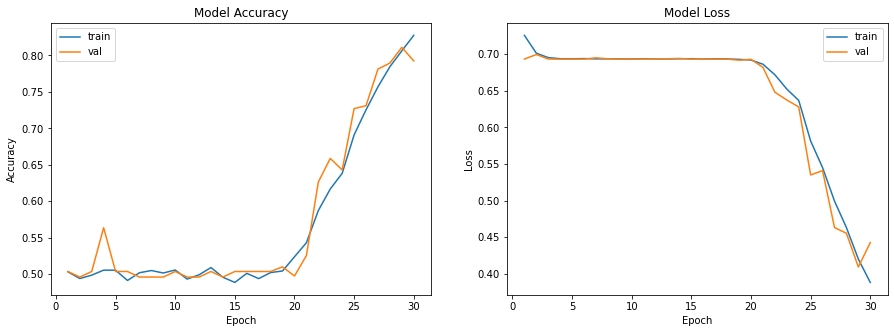

In [23]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['output_accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_output_accuracy'][-1])

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(range(1,len(history.history['output_accuracy'])+1), history.history['output_accuracy'])
axs[0].plot(range(1,len(history.history['val_output_accuracy'])+1),history.history['val_output_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='best')

axs[1].plot(range(1,len(history.history['output_loss'])+1),history.history['output_loss'])
axs[1].plot(range(1,len(history.history['val_output_loss'])+1),history.history['val_output_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='best')

plt.show()

In [24]:
print('train loss:', history.history['loss'][-2])
print('train accuracy:', history.history['output_accuracy'][-2])

print('dev loss:', history.history['val_loss'][-2])
print('dev accuracy:', history.history['val_output_accuracy'][-2])

train loss: 1.2777084112167358
train accuracy: 0.8061333298683167
dev loss: 1.2511447668075562
dev accuracy: 0.8109999895095825


In [25]:
predictions = model.predict(x_test)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Ide

Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:

Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_268202 in device /job:

In [26]:
print(predictions)

pred = np.array(predictions)

print(pred.shape)

[array([[0.9909376 , 0.00906237],
       [0.96362954, 0.03637045],
       [0.92566985, 0.07433013],
       ...,
       [0.3477302 , 0.65226984],
       [0.98023933, 0.01976064],
       [0.9764607 , 0.02353923]], dtype=float32), array([[9.5556521e-01, 4.4434793e-02],
       [9.9997580e-01, 2.4181325e-05],
       [8.5383487e-01, 1.4616519e-01],
       ...,
       [1.6601257e-01, 8.3398747e-01],
       [9.7703654e-01, 2.2963513e-02],
       [9.5825177e-01, 4.1748244e-02]], dtype=float32), array([[0.9849474 , 0.01505254],
       [0.9765009 , 0.02349906],
       [0.9045596 , 0.09544036],
       ...,
       [0.2387684 , 0.7612316 ],
       [0.9768571 , 0.02314291],
       [0.97582895, 0.02417101]], dtype=float32)]
(3, 5000, 2)


In [27]:
y_pred = []

for i in pred[2]:
    if i[0] < i[1]:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [28]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_test, y_pred)

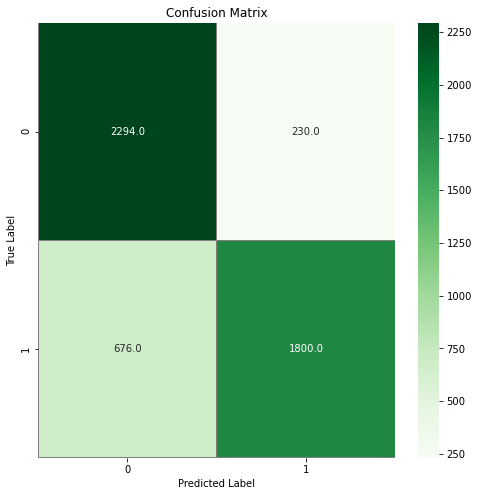

In [29]:
import seaborn as sns

f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens",linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [30]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['cat', 'dog'])

In [31]:
print(report)

              precision    recall  f1-score   support

         cat       0.77      0.91      0.84      2524
         dog       0.89      0.73      0.80      2476

    accuracy                           0.82      5000
   macro avg       0.83      0.82      0.82      5000
weighted avg       0.83      0.82      0.82      5000

